In [1]:
import os

from einops import rearrange
from shapely import Polygon, MultiPolygon
from matplotlib import colormaps
import numpy as np
import rasterio
import skimage
import matplotlib.pyplot as plt
import seaborn as sns

## v1

In [16]:
def preprocess(img, dims=2):
    if img.shape[-1] == 4:
        img = img[..., :-1]

    if img.dtype == np.uint8:
        img = img.astype(np.float32)
        img /= 255.

    if dims == 2:
        img = img.mean(-1)
        
    return img

In [265]:
# img = skimage.io.imread('/Users/erikstorrs/Downloads/target.png')
# img = preprocess(img)
# plt.imshow(img, cmap='gray')

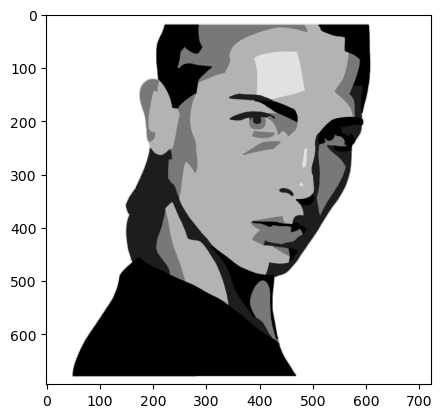

In [266]:
img = skimage.io.imread('/Users/erikstorrs/Downloads/all.png')
img = preprocess(img)
plt.imshow(img, cmap='gray')

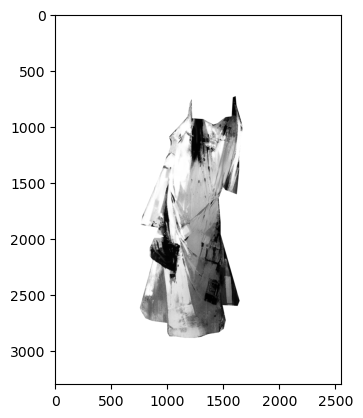

In [376]:
img = skimage.io.imread('/Users/erikstorrs/Downloads/dress.png')
img = preprocess(img)
plt.imshow(img, cmap='gray')

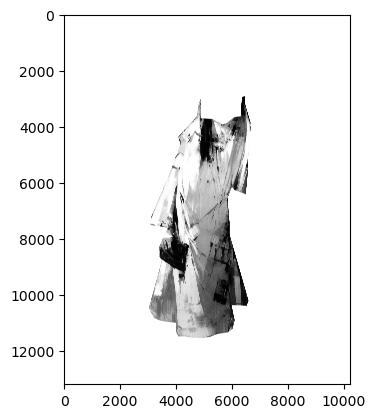

In [375]:
img = skimage.transform.rescale(img, 4.)
plt.imshow(img, cmap='gray')

In [377]:
def random_polygon(n, size, radius=10, t=1.):
    # rr, cc = skimage.draw.disk((size // 2, size // 2), radius, shape=(size, size))
    rr, cc = skimage.draw.circle_perimeter(size // 2, size // 2, radius)
    idxs = np.random.choice(np.arange(rr.shape[0]), size=n)
    rr, cc = rr[idxs], cc[idxs]
    
    m = skimage.draw.polygon2mask((size, size), np.stack([rr, cc]).T)

    return m

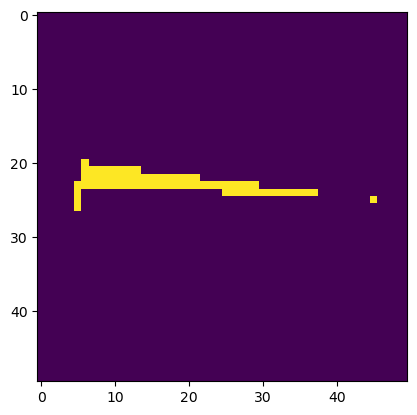

In [378]:
m = random_polygon(4, 50, radius=20)
plt.imshow(m)

In [379]:
stamps = []
# rads = [5, 10, 15]
rads = [5, 10, 20]
scalers = np.asarray([.001, .005, .0001]) * 4

for i in rads:
    # stamp = np.zeros((100, 100), dtype=bool)
    # rr, cc = skimage.draw.disk((50, 50), i, shape=(100, 100))
    # stamp[rr, cc] = True
    stamp = random_polygon(4, 100, i)
    stamps.append(stamp)

In [380]:
blank = np.zeros_like(img, dtype=bool)

for stamp, scale in zip(stamps, scalers):
    vals = np.random.rand(img.shape[0], img.shape[1])
    probs = (1 - img) * scale
    mask = probs > vals
    print(scale, np.count_nonzero(mask))
    for r, c in np.argwhere(mask):
        r1, r2 = r - 50, r + 50
        c1, c2 = c - 50, c + 50
        if r1 > 0 and c1 > 0 and r2 < img.shape[0] and c2 < img.shape[1]:
            blank[r1:r2, c1:c2] |= stamp

0.004 2191
0.02 10814
0.0004 208


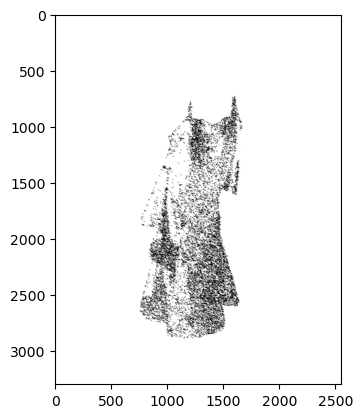

In [381]:
plt.imshow(blank, cmap='gray_r')

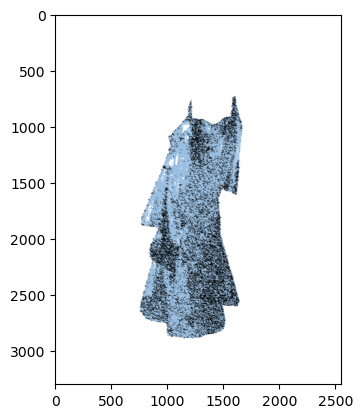

In [382]:
back = np.full((img.shape[0], img.shape[1], 3), 255, dtype=np.uint8)
m = img != 1
back[m] = [155, 191, 224]
back[blank] = 0
plt.imshow(back)


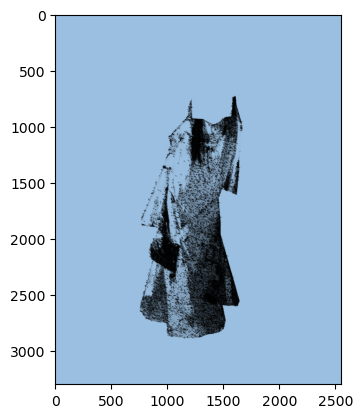

In [383]:
back = img.copy()

back = np.stack([back] * 3, -1)
back *= np.asarray([155, 191, 224]) / 255
# back *= np.asarray([74, 46, 232]) / 255
back *= 255
back = back.astype(np.uint8)

m = img != 1
back[blank] = 0

plt.imshow(back)

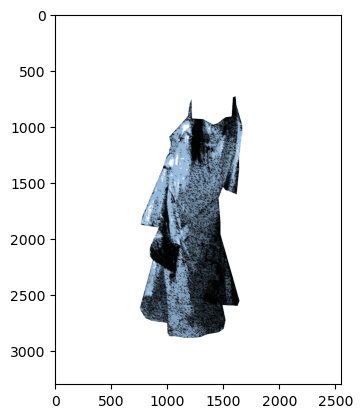

In [384]:
# back = np.full((img.shape[0], img.shape[1], 3), 255, dtype=np.uint8)
# back[img != 1] = [155, 191, 224]
# back[blank] = 0
# plt.imshow(back)

alphas = np.zeros((img.shape[0], img.shape[1], 1), dtype=np.uint8)
alphas[m] = 255

back = np.concatenate((back, alphas), -1)
plt.imshow(back)
skimage.io.imsave('/Users/erikstorrs/Downloads/blue.png', back)

## v2

In [2]:
vectors = np.asarray([45, 120])


In [3]:
v = vectors[0]
v

np.int64(45)

In [4]:
pts = np.asarray([
    [0., 0],
    [1, 1],
    [2, 1]
])

# pts = np.asarray([
#     [2, 1],
#     [1, 1],
#     [0., 0],
# ])

In [86]:
poly = np.polynomial.Polynomial.fit(pts[:, 0], pts[:, 1], 4)

/Users/erikstorrs/miniconda3/envs/art/lib/python3.12/site-packages/numpy/polynomial/polynomial.py:1476: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


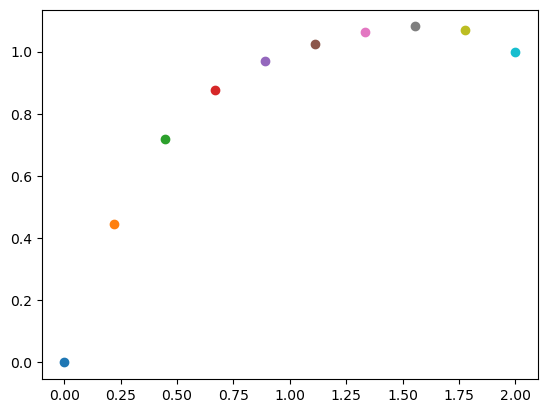

In [87]:
for x in xs:
    y = poly(x)
    plt.scatter(x, y)

In [80]:
def get_perp_units(poly, x):
    deriv = poly.deriv(1)
    print(deriv(x))
    slope = np.asarray([deriv(x), 1])
    slope /= np.linalg.norm(slope)

    perp1 = np.asarray([slope[1], -slope[0]])
    perp1 /= np.linalg.norm(perp1)
    perp2 = np.asarray([-slope[1], slope[0]])
    perp2 /= np.linalg.norm(perp2)

    # plt.scatter(*slope)
    # plt.scatter(*perp1)
    # plt.scatter(*perp2)
    # plt.axis('equal')
    # plt.show()

    return perp1, perp2, slope


In [81]:
perp1, perp2, slope = get_perp_units(poly, .2)

1.2999999999999996


(np.float64(-0.6798274983474072),
 np.float64(0.8627407266023146),
 np.float64(-0.8718863880150601),
 np.float64(0.8718863880150601))

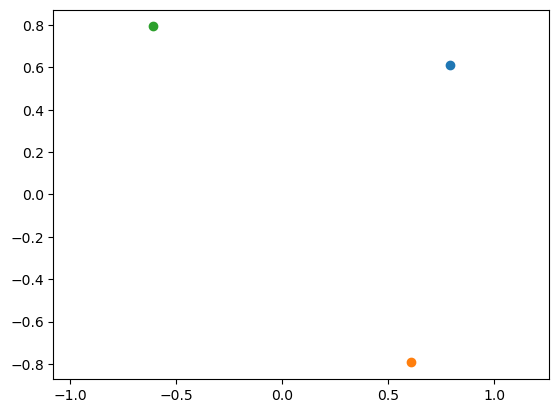

In [55]:
plt.scatter(*slope)
plt.scatter(*perp1)
plt.scatter(*perp2)
plt.axis('equal')

(np.float64(-0.6798274983474072),
 np.float64(0.8627407266023146),
 np.float64(-0.8718863880150601),
 np.float64(0.8718863880150601))

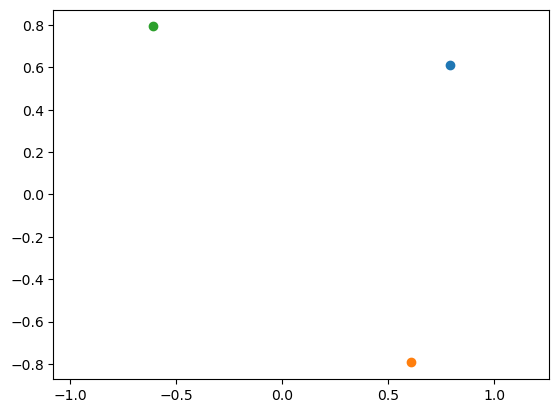

In [56]:
plt.scatter(*slope)
plt.scatter(*perp1)
plt.scatter(*perp2)
plt.axis('equal')

In [66]:
n = 10
# xs = np.linspace(0, slope[0], n)
xs = np.linspace(0, pts[:, 0].max(), n)
xs

array([0.        , 0.22222222, 0.44444444, 0.66666667, 0.88888889,
       1.11111111, 1.33333333, 1.55555556, 1.77777778, 2.        ])

In [82]:
# mag_range = (.5, 2.)
mag_range = (1, 1)
heads, tails, slopes = [], [], []
for x in xs:
    y = poly(x)
    perp1, perp2, slope = get_perp_units(poly, x)
    perp1 *= np.random.uniform(mag_range[0], mag_range[1])
    perp2 *= np.random.uniform(mag_range[0], mag_range[1])

    slopes.append(slope)
    offset = np.asarray([x, y])
    heads.append(perp1 + offset)
    tails.append(perp2 + offset)

slopes = np.asarray(slopes)
heads = np.stack(heads)
tails = np.flip(np.stack(tails))

# heads = heads[np.argsort(heads[:, 0])]
# tails = tails[np.argsort(-tails[:, 0])]

coords = np.concat((heads, tails))
coords

1.4999999999999996
1.2777777777777775
1.0555555555555554
0.8333333333333331
0.611111111111111
0.38888888888888884
0.16666666666666685
-0.05555555555555519
-0.2777777777777774
-0.4999999999999996


array([[ 0.5547002 , -0.83205029],
       [ 0.83853048, -0.47886303],
       [ 1.13218909, -0.15805145],
       [ 1.43488795,  0.13759338],
       [ 1.74217072,  0.4168216 ],
       [ 2.04311578,  0.68693645],
       [ 2.31972726,  0.94671212],
       [ 2.55401591,  1.17892681],
       [ 2.74129569,  1.35406362],
       [ 2.89442719,  1.4472136 ],
       [ 0.5527864 ,  1.10557281],
       [ 0.81877589,  0.81425987],
       [ 1.06798677,  0.5570952 ],
       [ 1.2755101 ,  0.34693941],
       [ 1.41182898,  0.17910644],
       [ 1.45972161,  0.03560706],
       [ 1.41796218, -0.10155461],
       [ 1.29385392, -0.2433002 ],
       [ 1.09614698, -0.39408604],
       [ 0.83205029, -0.5547002 ]])

In [76]:
slopes

array([[ 0.83205029,  0.5547002 ],
       [ 0.787505  ,  0.61630826],
       [ 0.72595268,  0.68774465],
       [ 0.6401844 ,  0.76822128],
       [ 0.52145001,  0.85328183],
       [ 0.36244626,  0.93200467],
       [ 0.16439899,  0.98639392],
       [-0.05547002,  0.99846035],
       [-0.26764386,  0.96351791],
       [-0.4472136 ,  0.89442719]])

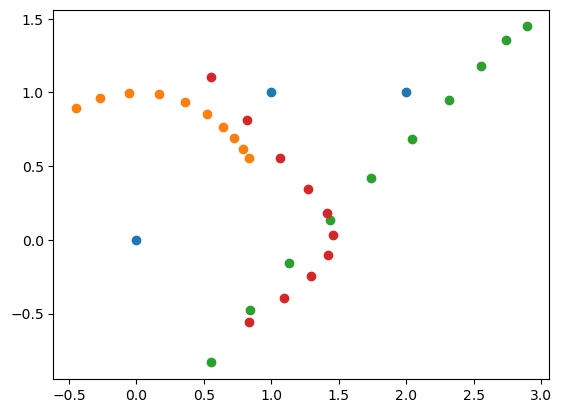

In [77]:
plt.scatter(pts[:, 0], pts[:, 1])
plt.scatter(slopes[:, 0], slopes[:, 1])
plt.scatter(heads[:, 0], heads[:, 1])
plt.scatter(tails[:, 0], tails[:, 1])

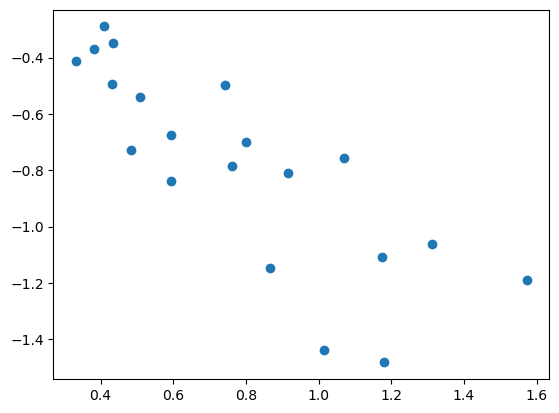

In [42]:
plt.scatter(coords[:, 0], coords[:, 1])

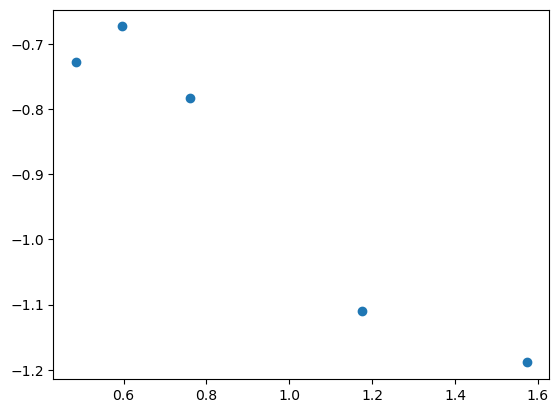

In [46]:
idxs = np.random.choice(np.arange(coords.shape[0]), size=5, replace=False)
idxs = np.sort(idxs)
selected = coords[idxs]
plt.scatter(selected[:, 0], selected[:, 1])

In [47]:
idxs

array([ 4, 10, 13, 16, 18])

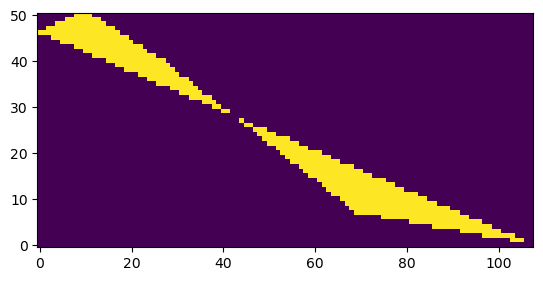

In [48]:
scale = 100.
scaled = selected * scale
scaled -= scaled.min(0)
scaled = scaled.astype(int)
scaled = scaled[:, [1, 0]]
size = scaled.max(0)
m = skimage.draw.polygon2mask(size, scaled)
plt.imshow(m)
plt.gca().invert_yaxis()

(np.float64(-2.35), np.float64(49.35), np.float64(-4.65), np.float64(97.65))

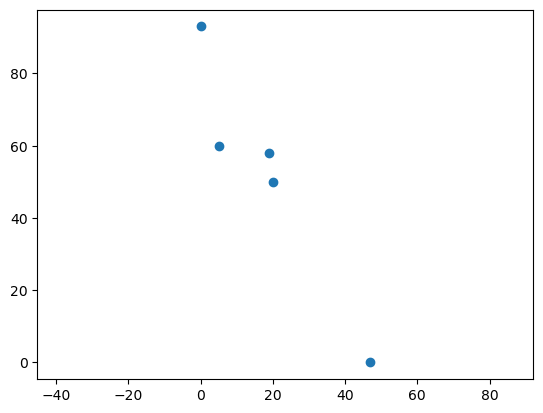

In [37]:
plt.scatter(scaled[:, 1], scaled[:, 0])
plt.axis('equal')

## v3

In [352]:
def preprocess(img, dims=2):
    if img.shape[-1] == 4:
        img = img[..., :-1]

    if img.dtype == np.uint8:
        img = img.astype(np.float32)
        img /= 255.

    if dims == 2:
        img = img.mean(-1)
        
    return img

In [207]:
pts = np.asarray([
    [0., 0],
    [2, 1]
]) # y, x

pts = pts[:, [1, 0]]

m =  (pts[1, 1] - pts[0, 1]) / (pts[1, 0] - pts[0, 0])
m

np.float64(2.0)

In [309]:
def generate_coords(m, mag_range=(.1, .2), n=10):
    m = -m # make negative bc y is flipped for images
    slope = np.asarray([1, m])
    slope /= np.linalg.norm(slope)
    
    perp1 = np.asarray([slope[1], -slope[0]])
    perp1 /= np.linalg.norm(perp1)
    perp2 = np.asarray([-slope[1], slope[0]])
    perp2 /= np.linalg.norm(perp2)

    xs = np.linspace(0, slope[0], n)
    ys = xs * m

    heads, tails = [], []
    for x, y in zip(xs, ys):
        v1 = perp1 * np.random.uniform(mag_range[0], mag_range[1])
        v2 = perp2 * np.random.uniform(mag_range[0], mag_range[1])
    
        offset = np.asarray([x, y])
        v1 += offset
        v2 += offset
        
        heads.append(v1)
        tails.append(v2)
    
    heads = np.stack(heads)
    tails = np.flip(np.stack(tails), 0)
    
    coords = np.concat((heads, tails))
    return coords

def get_stamp(coords, n=8, scale=10.):
    idxs = np.random.choice(np.arange(coords.shape[0]), size=n, replace=False)
    idxs = np.sort(idxs)
    selected = coords[idxs]

    scaled = selected * scale
    scaled -= scaled.min(0)
    scaled = scaled.astype(int)
    scaled = scaled[:, [1, 0]]
    size = scaled.max(0)
    
    return skimage.draw.polygon2mask(size, scaled)

def stamp_from_slope(m, mag_range=(.1, .2), n=10, scale=50.):
    coords = generate_coords(float(m), mag_range=mag_range, n=n)
    stamp = get_stamp(coords, scale=scale)
    return stamp

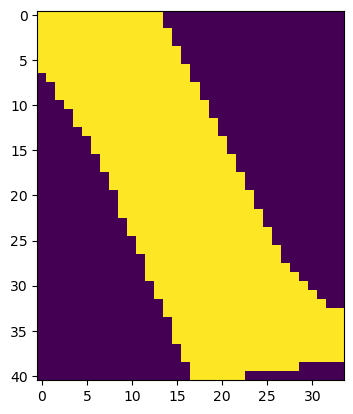

In [311]:
stamp = stamp_from_slope(-2., mag_range=(.1, .2), n=10, scale=50.)
plt.imshow(stamp)

In [346]:
img = np.ones((1000, 1000, 3), dtype=np.uint8) * 255


In [347]:
def apply_mark(img, color, slope, pt, mag_range=(.1, .2), scale=50.):
    y, x = pt
    stamp = stamp_from_slope(slope, mag_range=mag_range, scale=scale)
    h, w = stamp.shape
    
    r_minus =  y - h // 2
    c_minus = x - w // 2
    
    if r_minus <= 0:
        r1 = 0
        r2 = h + r1 - np.abs(r_minus)
        stamp_r1 = np.abs(r_minus)
        stamp_r2 = stamp_r1 + (r2 - r1)
    else:
        r1 = r_minus
        r2 = min(img.shape[0], r1 + h)
        stamp_r1 = 0
        stamp_r2 = stamp_r1 + (r2 - r1)
    
    if c_minus <= 0:
        c1 = 0
        c2 = w + c1 - np.abs(c_minus)
        stamp_c1 = np.abs(c_minus)
        stamp_c2 =  stamp_c1 + (c2 - c1)
    else:
        c1 = c_minus
        c2 = min(img.shape[1], c1 + w)
        stamp_c1 = 0
        stamp_c2 = stamp_c1 + (c2 - c1)
    
    stamp_mask = stamp[stamp_r1:stamp_r2, stamp_c1:stamp_c2]
    
    img[r1:r2, c1:c2][stamp_mask] = color

In [350]:
color = [255, 0, 0]
apply_mark(img, color, 2., [200, 100], mag_range=(.1, .2), scale=50.)

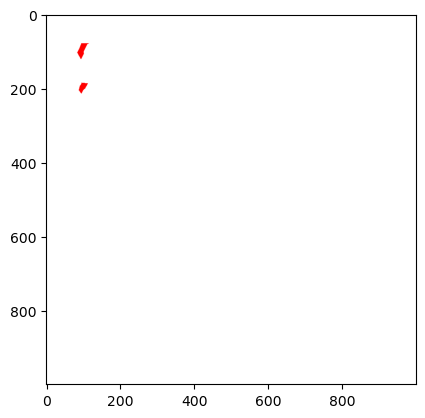

In [351]:
plt.imshow(img)

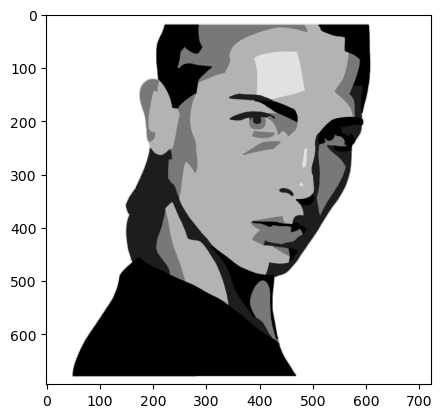

In [353]:
img = skimage.io.imread('/Users/erikstorrs/Downloads/all.png')
img = preprocess(img)
plt.imshow(img, cmap='gray')

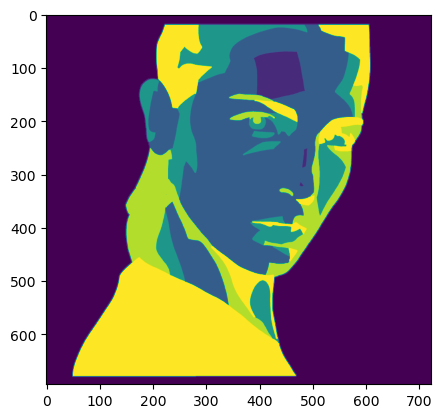

In [357]:
probs = 1 - (img / img.max())
plt.imshow(probs)

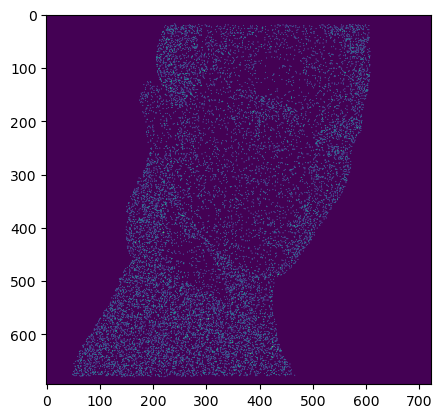

In [389]:
vals = np.random.rand(*probs.shape) * 10.
mask = vals < probs
plt.imshow(mask)

In [390]:
pts = np.argwhere(mask)
pts.shape, pts[:5]

((13209, 2),
 array([[ 18, 241],
        [ 19, 286],
        [ 19, 530],
        [ 19, 569],
        [ 19, 575]]))

In [407]:
blank = np.ones((img.shape[0], img.shape[1], 3), dtype=np.uint8) * 255

# m = 100.
# mag_range=(.01, .05)
# scale=50.
# color = [20, 20, 20]

m = 30.
mag_range=(.1, .1)
scale=10.
color = [20, 20, 20]



for pt in pts:
    apply_mark(blank, color, m, pt, mag_range=mag_range, scale=scale)

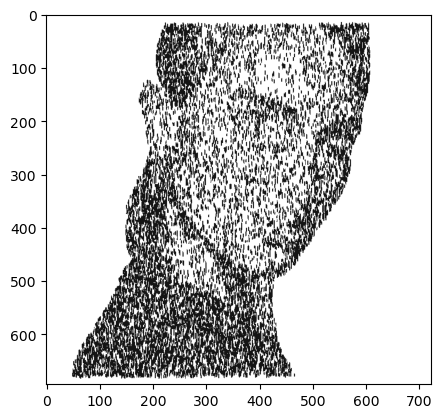

In [408]:
plt.imshow(blank)

## V4